# TP3 - Modelação de uma Reacção Química

O trabalho da terceira aula prática é dedicado ao estudo de uma reacção química usando métodos de química quântica. 



## Preparação do Ambiente Python

Este _notebook_ é usado como protocolo e folha de excercício deste trabalho é uma tecnologia que permite combinar texto formatado com código Python. Existem várias implementações desta tecnologia (ver TP2). No entanto, este trabalho prático requer o uso de um programa externo (`xtb`) e de um pacote externo do python (`pyscf`).  A configuração destes pacotes pode depender do ambiente usado, pelo que este trabalho foi desenhado para **correr apenas na plataforma Google Colab**. A Google Colab é uma implementação de cálculo na _cloud_ desenvolvida pela Google e disponível em https://colab.research.google.com/ . Possui algumas vantagens relativamente ao uso de notebooks da Jupyter: os cálculos correm numa máquina remota da Google, não há nececidade de instalar software no computador local (basta um browser recente) e é gratuito, para o nível de acesso mais básico.

O ambiente oferecido pelo Google Colab ja inclui vários pacotes necessários para cálculo numérico, gráficos e tratamento de dados. Para este trabalho específico, apenas é necessário fazer a instalação do pacote `pyscf` para química quântica, com as extensões `semiempirical` (para hamiltonianos semi-empíricos) e `geomopt` (para optimização de geometrias). É também necessário modificar a variável `path` de forma a que o python consiga encontrar os pacotes instalados. 

Finalmente também é necessário instalar e configurar o `xtb`, incluíndo definir um par de funções necessário para que este corra a partir dos comandos do python.

In [ ]:
# install py3Dmol
!pip install --user py3Dmol

# install openbabel (only the software, not the python bindings)
!apt-get install openbabel

# install pyscf
!pip install --user pyscf[semiempirical,geomopt]
import sys
sys.path.append('/root/.local/lib/python3.7/site-packages')

# install XTB
!wget -c https://github.com/grimme-lab/xtb/releases/download/v6.5.1/xtb-6.5.1-linux-x86_64.tar.xz
!tar xf xtb-6.5.1-linux-x86_64.tar.xz
!export PATH=/content/xtb-6.5.1/bin:${PATH}

# aditional functions for xtb
import subprocess
def shell(cmd, shell=True):
  "runs a command in the linux shell, adapted from Jimmy Kromann."
  if shell:
    p = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  else:
    p = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  output, err = p.communicate()
  return output

def run_xtb(args):
  return shell(f"ulimit -s unlimited; OMP_STACKSIZE=12G OMP_MAX_ACTIVE_LEVELS=1 /content/xtb-6.5.1/bin/xtb {args}")


## Importar Pacotes e Carregar Funções Utilitárias

Depois de configurar o seu ambiente python, deverá executar a célcula seguinte, de forma a carregar os pacotes necessários (instrução `import`), assim como definir algumas funções, classes e constantes usadas ao longo do trabalho.

In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyscf
import py3Dmol

atomic_symbols=['XX','H','He','Li','Be','B','C','N','O','F','Ne',
                'Na','Mg','Al','Si','P','S','Cl','Ar']

class Molecule():
  def __init__(self,fn=None, name=None):
    self.name='None'
    self.symbols=list()
    self.geo=np.array([])
    if fn:
      self.read_xyz(fn)
    if name:
      self.name=name

  def natoms(self):
      return len(self.symbols)
  
  def show(self, label=None): 
    p = py3Dmol.view()
    p.addModel(self.write_xyz())
    #p.setStyle({'stick':{}})
    p.setStyle({'stick':{},'sphere':{'scale':0.3}})
    p.setBackgroundColor('0xeeeeee')
    if label == 'C':
      for i,s in enumerate(self.symbols):
        if s.upper().strip()=='C':
          p.addLabel(f"C{i+1}",{'position': {'x':self.geo[i,0], 'y':self.geo[i,1], 'z':self.geo[i,2]}})
    p.zoomTo()
    p.show()

  def read_xyz(self, fn):
    "Reads a XYZ file"
    with open(fn,'r') as f:
      data = f.readlines()
    natoms = int(data[0])
    g = list()
    for i in range(2,2+natoms):
      l = data[i].split()
      self.symbols.append(l[0].capitalize())
      g.append(list(map(float,l[1:4])))
    self.geo=np.array(g)

  def centre_location(self):
    "returns the location of the geometrical centre as a vector"
    return self.geo.mean(axis=0)

  def shift(self, displacement):
    "Displaces the molecule as a whole, given a 3D vector (np.array)"
    self.geo += displacement

  def center(self):
    "Displaces the molecule so that its geometrical centre is at the origin."
    self.shift(-self.centre_location())

  def write_xyz(self,fn=None):
    s = f"{self.natoms()}\n Created by Molecule Class\n"
    for n in range(self.natoms()):
        s += f"{self.symbols[n]:3s}"
        for i in range(3):
          s += f" {self.geo[n,i]:16.6f}"
        s += '\n'
    if fn:
      with open(fn,'w') as f:
        f.write(s)
    else:
      return s

def extract_geo(ifn, n, ofn):
  """Extrai a geometria n de um ficheiro do tipo xtb*.log (começando em 1) e 
  guarda essa geometria num ficheiro chamod ofn"""
  with open(ifn,'r') as f:
    data=f.readlines()
  natoms = int(data[0])
  start = (natoms+2)*(n-1)
  end = start + natoms + 2
  with open(ofn,'w') as f:
    for line in data[start:end]:
      f.write(line)

def llm(fn1, fn2, nome, n=10, xtb_args='' ):
  """Corre o xtb de forma a obter o perfil da LLM entre dois estados,
  guardados no ficheiro fn1, e fn2"""
  e1 = Molecule(fn1)
  e2 = Molecule(fn2)
  energias = list()
  for i,k in enumerate(np.linspace(0.0, 1.0, n)):
    point = Molecule()
    point.symbols=e1.symbols
    point.name=f"LMM point {n}"
    point.geo = (1.0-k)* e1.geo + k*e2.geo
    point.write_xyz(f"{nome}-lmm{i:03d}-guess.xyz")
    run_xtb(f"{nome}-lmm{i:03d}-guess.xyz --scc --namespace {nome}-lmm{i:03d} {xtb_args} > {nome}-lmm{i:03d}.out")
    with open(f"{nome}-lmm{i:03d}.out", 'r') as f:
      data = f.readlines()
    for line in data:
      if ' | TOTAL ENERGY ' in line:
        energias.append(float(line.split()[-3]))
  for i,e in enumerate(energias):
    print(f"{i:5d} {e:16.5f}")
  plt.plot(energias)
  plt.show()

def plot_trj_energy(fn):
  data=open(fn,'r').readlines()
  e=list()
  for line in data:
    if 'energy:' in line:
      l=line.split()
      for i,token in enumerate(l):
        if token=='energy:':
          e.append(float(l[i+1]))
  e = np.array(e)
  e = 2625.5*(e-e.min())
  fig,ax = plt.subplots()
  ax.scatter(np.arange(1,len(e)+1),e)
  ax.set_xlabel("Passo (n)")
  ax.set_ylabel("Energia Relativa (kJ/mol)")
  plt.show()

def animate_trj(fn):
  data = open(fn,'r').readlines()
  xyzview = py3Dmol.view(width=400,height=400)
  xyzview.addModelsAsFrames(''.join(data),'xyz')
  xyzview.setStyle({'stick':{},'sphere':{'scale':0.3}})
  xyzview.setBackgroundColor('0xeeeeee')
  xyzview.animate({'loop': 'forward'})
  xyzview.zoomTo()
  xyzview.show()

def g98_animate_mode(fn,n_vib,scale=1.0):
  data = open(fn,'r').readlines()
  ZZ = list()
  geo = list()
  displ = list()
  # ler a geometria
  geo_start=100000000000000
  geo_end = -1
  for n,line in enumerate(data):
    if 'Coordinates' in line:
      geo_start = n+3
    if (n>geo_start) and '--------' in line:
      geo_end = n
      break
  for n in range(geo_start,geo_end):
    l =  data[n].split()
    ZZ.append(int(l[1]))
    geo.append(l[-3:])
  symbols = [atomic_symbols[z] for z in ZZ]
  natoms = len(symbols)
  vib_start = geo_end + 7
  vib_step = 9 + natoms
  for i in range(vib_start,len(data),vib_step):
    if n_vib in list(map(int,data[i].split())):
      v_ind = list(map(int,data[i].split())).index(n_vib)
      v_start = i + 9
      v_end = i + vib_step
      for j in range(v_start,v_end):
        l = data[j].split()
        displ.append(list(map(float,l[2+(3*v_ind):5+(3*v_ind)])))
      break
  for n in range(natoms):
    for j in range(3):
      displ[n][j] *= scale
  xyz=f"{natoms}\n* (null), Energy   -1000.0000000\n"
  for n in range(natoms):
    xyz += f"{symbols[n]}"
    for j in range(3):
      xyz += f" {geo[n][j]}"
    for j in range(3):
      xyz += f" {displ[n][j]}"
    xyz += '\n'
  xyzview = py3Dmol.view(width=400,height=400)
  xyzview.addModel(xyz,'xyz',{'vibrate': {'frames':10,'amplitude':1}})
  xyzview.setStyle({'stick':{},'sphere':{'scale':0.3}})
  xyzview.setBackgroundColor('0xeeeeee')
  xyzview.animate({'loop': 'backAndForth'})
  xyzview.zoomTo()
  xyzview.show()

def compile_reaction_data(r_fn, ts_fn, p_fn):
  r={'E':0.0,'H':0.0,'G':0.0}
  ts={'E':0.0,'H':0.0,'G':0.0,'Ivib':0.0}
  p={'E':0.0,'H':0.0,'G':0.0}
  # reactant
  data=open(r_fn).readlines()
  for line in data[-100:]:
    if '| TOTAL ENERGY ' in line:
      r['E']=float(line.split()[-3])
    if '| TOTAL ENTHALPY' in line:
      r['H']=float(line.split()[-3])
    if 'TOTAL FREE ENERGY' in line:
      r['G']=float(line.split()[-3])
  # TS
  data=open(ts_fn).readlines()
  for line in data[-100:]:
    if '| TOTAL ENERGY ' in line:
      ts['E']=float(line.split()[-3])
    if '| TOTAL ENTHALPY' in line:
      ts['H']=float(line.split()[-3])
    if 'TOTAL FREE ENERGY' in line:
      ts['G']=float(line.split()[-3])
  data = open(ts_fn.replace('.out','.vibspectrum'),'r').readlines()
  for line in data[4:]:
    try:
      freq=float(line[24:38].strip())
    except:
      freq=1.0
    if freq < -1.0:
      ts['Ivib']=freq
      break
  # product
  data=open(p_fn).readlines()
  for line in data[-100:]:
    if '| TOTAL ENERGY ' in line:
      p['E']=float(line.split()[-3])
    if '| TOTAL ENTHALPY' in line:
      p['H']=float(line.split()[-3])
    if 'TOTAL FREE ENERGY' in line:
      p['G']=float(line.split()[-3])
  reactant = Molecule(r_fn.replace(".out",'.xtbopt.xyz'))
  reactant.show()
  print("Reactant final geometry")
  g98_animate_mode(ts_fn.replace('.out','.g98.out'),1,1.0)
  print("Animation of the Reaction Coord. at the TS")
  product = Molecule(p_fn.replace(".out",'.xtbopt.xyz'))
  product.show()
  print("Product final geometry")
  Eh2kjmol = 2625.5 # conversao Eh -> kJ/mol
  de_d = (p['E']-r['E']) * Eh2kjmol
  dh_d = (p['H']-r['H']) * Eh2kjmol
  dg_d = (p['G']-r['G']) * Eh2kjmol
  ea_d = (ts['E']-r['E']) * Eh2kjmol
  ha_d = (ts['H']-r['H']) * Eh2kjmol
  ga_d = (ts['G']-r['G']) * Eh2kjmol
  de_i = (r['E']-p['E']) * Eh2kjmol
  dh_i = (r['H']-p['H']) * Eh2kjmol
  dg_i = (r['G']-p['G']) * Eh2kjmol
  ea_i = (ts['E']-p['E']) * Eh2kjmol
  ha_i = (ts['H']-p['H']) * Eh2kjmol
  ga_i = (ts['G']-p['G']) * Eh2kjmol
  print(f"           {'Energy':^16s} {'Enthalpy':^16s} {'Gibbs Energy':^16s}")
  print(f" Delta (D) {de_d:16.2f} {dh_d:16.2f} {dg_d:16.2f}")
  print(f" Eact (D)  {ea_d:16.2f} {ha_d:16.2f} {ha_d:16.2f}")
  print(f" Delta (I) {de_i:16.2f} {dh_i:16.2f} {dg_i:16.2f}")
  print(f" Eact (I)  {ea_i:16.2f} {ha_i:16.2f} {ha_i:16.2f}")

  print(f"Value of the imaginary frequency at TS: {ts['Ivib']:20.2f}")


# Reacção de Diels Alder

A reacção de Diels Alder é a adição de um dieno conjugado a un dienófilo, levando à formação de um derivado de ciclohexeno. O arquétipo desta reacção é a adição de etileno (dienófilo) ao butadieno:

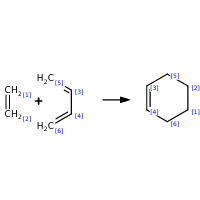

Este trabalho estuda este mecanismo de adição usando um método de *Tight Binding* para a exploração inicial da superfície de energia potencial. As geometrias obtidas para os estados iniciais, finais e de transição são depois usadas para calculos mais refinados da energia electrónica, obtendo-se assim uma visão de como o balanço energético ($|delta E$) e a energia de activaçao ($E^\ddagger$) variam com o nível do método de química quântica usado para tratar o sistema.

Por fim, este procedimento é repetido para os sistemas:
* 1-cloroetileno + butadieno
* etileno + 1-cloro-butadieno
* etileno + 2-cloro-butadieno

Tendo em vista o estabelecimento de regas re reactividade baseadas na halogenação do dieno e dienófilo. A primeira parte do trabalho (etileno + butadieno) é fornecida como demonstração.

## Sistema 1: Etileno + Butadieno

O estudo desta reacção passa por varias fases, resumidas abaixo:
1. Definição do estado inicial (ou final) do sistema.
1. Execução de um cálculo de varrimento da superfície de energia potencial (PES) para determinação do estado final (ou inicial) e geometria plaussível do estado de transição.
1. Cálculo do caminho de menor energia entre o estado final e inicial.
1. Caracterização do TS (cálculo de frequências vibracionais e análise da coordenada de reacção).
1. Caracterização dos estados inicial (reagentes) e final (produtos) através do cálculo de freuências vibracionais.
1. Extracção de parâmetros termoquímicos.
1. Cálculo de $\Delta E$, $\Delta H$, $\Delta G$ e $E^\ddagger$.

### Definição do estado inicial (ou final) do sistema

Uma vez que o estado final do sistema é mais simples (uma só molécula), esta reacção vai ser modelada "de trás para a frente". Para isso, começamos pela representação SMILE do nosso produto (ciclohexeno), a qual é gravada num ficheiro com a extenção `.smi`. Depois, usamos o openbabel para converter de SMILES para XYZ, com geração das coordenadas 3D. Por fim, abrimos o ficheiro xyz formado, e inspeccionamos visualmente. Em alternativa, poderá fazer download do ficheiro `ciclohexeno.xyz` e usar outra ferramenta de visualização, como o VMD.

In [ ]:
prod_smile = "[CH2]1[CH2][CH]=[CH][CH2][CH2]1"

with open('ciclohexeno.smi','w') as f:
  f.write(prod_smile+'\n')

! obabel ciclohexeno.smi -Ociclohexeno.xyz -h --gen3d

chex_mol = Molecule('ciclohexeno.xyz')
chex_mol.show(label='C')

Nós desejamos quebrar as ligações C1-C4 e C11-C14, usando um cálculo de varrimento da superfície de energia potencial. Para isso temos que preparar um ficheiro de configuração para o programa xtb. Nesse ficheiro, o varrimento da PES ocorre em dois passos: primeiro criamos um constrangimento nas ligações que pretendemos manupular, usando o grupo `$constrain`. Só depois é que podemos definir a forma como pretendemos "esticar" as ligações em causa: neste caso, de 1.1 até 6.0 Å, em 60 passos.

Finalmente corremos o xtb, usando as especificações da linha de comando, conforme explica o manual (https://xtb-docs.readthedocs.io/en/latest/setup.html).

In [ ]:
with open('scan_pes.conf','w') as f:
  f.write("""$cma
$constrain
 force constant=3.0
 distance: 1, 4, auto
 distance: 11, 14, auto
$scan
 mode = concerted
 1: 1.3, 5.0, 60
 2: 1.3, 5.0, 60
$end
""")

start=time.time()
run_xtb("ciclohexeno.xyz --opt --input scan_pes.conf --namespace scan_pes -a 0.1 --etemp 1500 > scan_pes.out")
print(f"O cálculo demorou {time.time()-start:0.1f} segundos.")

No final do cálculo, o `xtb` gera uma série de ficheiros. Para este tipo de cálculo, os ficheiros mais importantes são o ficheiro terminado em `.out`, o qual contém todo o output dos cálculos, incluindo todas as propriedades calculadas a cada passo. Para além do ficheiro com o output, temos também o ficheiro terminado em `.xtbscan.log` o qual é um ficheiro em formato XYZ com as geometrias de menor energia (sujeitas ao constrangiemnto das ligações manipuladas) e a respectiva energia. Nas primeiras células deste _notebook_ definimos funções para animar esta trajéctória, assim como para fazer o gráfico da energia em função do passo.

In [ ]:
animate_trj('/content/scan_pes.xtbscan.log')
plot_trj_energy('/content/scan_pes.xtbscan.log')

O gráfico permite verificar alguns problemas:
1. O valor inicial das ligações (1.3 Å) é mais curto que a distância de equilibrio.
1. O processo de quebra das ligações é exoenergético, pelo que a reacção que pretendemos estudar será exoenergética (com $ΔE≈280$ kJ/mol)
1. O varrimento da PES não dá origem a uma superfície contínua.
1. Os passos 10 e 20 estão seguramente próximos, mas em lados opostos do estado de transição.

Tendo em conta este último resultado, vamos estimar o caminho de reacção entre estes dois pontos. Para isso, temos primeiro que isolar essses dois pontos (copiar as geometrias do ficheiro de trajéctória para ficheiros xyz só com as geometrias de interesse). Depois é necessário correr um cálculo do tipo `path` no xtb (de novo, é preciso criar um ficheiro com a configuração do cálculo). **Daqui para a frente vamos abordar a reacção no seu sentido original** ou seja, o ponto 20 será etiquetado como estado inicial (reagentes) e o ponto 10 como estado final (produto).

In [ ]:
extract_geo('/content/scan_pes.xtbscan.log',10,'final-guess.xyz')
extract_geo('/content/scan_pes.xtbscan.log',20,'initial-guess.xyz')

with open('path.conf','w') as f:
  f.write("""
$path
 # number of runs for pathfinder
 nrun = 5
 # number of points on the path to optimize
 #nopt = 20
 npoint = 20
 # number of steps to optimize the points on the path
 anopt = 1
 # factor for RMSD criterium pushing away from the reactant structure
 kpull = -0.1
 # factor for RMSD criterium pulling towards the product structure
 kpush = 0.01
 # width of the RMSD criterium
 alp = 0.001
$end
""")

start=time.time()
run_xtb("initial-guess.xyz --path final-guess.xyz --input path.conf --namespace react1-path > react1-path.out")
print(f"O cálculo demorou {time.time()-start:0.1f} segundos.")

Os cálculos do tipo `path`, quando bem sucedidos, geram uma série de ficheiros importantes:
* Ficheiro `.out` contém o output do programa
* Ficheiro `.xtbpath.xyz` contém a trajéctória de menor energia encontrada.
* Ficheiro `.xtbpath_ts.xyz` contém a geometria do estado de transição.

Podemos inspecionar a geometria do estado de transição e verificar que esta se encontra algures entre o estado final e o estado inicial.


In [ ]:
ts_mol = Molecule('react1-path.xtbpath_ts.xyz')
ts_mol.show()

No entanto, a inspecção visual do estado de transição é insuficiente para verificar a sua natureza. Um estado de transição deverá apresentar uma e só uma frequência vibracional negativa (imaginária). Para verificar isto devemos fazer um cálculo de frequências, o qual também permite estimar os valores da entalpia e função de Gibbs a 289.15 K.

In [ ]:
start=time.time()
run_xtb("react1-path.xtbpath_ts.xyz --hess --namespace react1-TS-hess > react1-TS-hess.out")
run_xtb("initial-guess.xyz --ohess --namespace react1-R-ohess > react1-R-ohess.out")
print(f"O cálculo demorou {time.time()-start:0.1f} segundos.")

Os cálculos de freqências geram alguns ficheiros interessantes:
* Ficheiros `.out`  contém o output principal do programa (incluindo os valores das propriedades termoquímicas).
* Ficheiros `.g98.out` contém os dados das vibrações no formato do software Gaussian 98, o qual pode ser usado por vários pacotes de visualização, tais como o molden ou o avogadro.
* Ficheiros `.charges` com a carga de Muliken de cada átomo no sistema
* Ficheiros `.wbo` com a ordem de ligação de Widberg entre os átomos do sistema.
* Fihcheiros `.vibspectrum` com o sumário do espectro de Infravermelho e Raman (números de onda, intensidades e aplicação das regras de selecção).

No nosso caso, vamos usar uma função definida no início do _notebook_ para animar o modo de vibração correspondente à coordenada de reacção, a partir do ficheiro `g98.out`). Olhando para o conteúdo do ficheiro `react1-TS-hess.g98.out`, podemos ver que o modo vibracional com frequência assciada negativa (imaginária) é o modo número 1.

In [ ]:
g98_animate_mode('/content/react1-TS-hess.g98.out',1, scale=1.0)

Feita a verificação do movimento associado à coordenada de reacção, resta-nos optimizar a geometria dos reagentes e produtos, a partir dos pontos usados para fazer o path. Para este fim, poderíamos usar cálculos de optimização de geometria, os quais teriam que ser seguidos de um cálculo de frequências (para identificar as geoemtrias obtidas como verdadeiros mínimos da PES, e para calcular os parâmteros termoquímicos). No caso do software stb, estes dois tipos de cálculos podem ser combinados num único cálculo do tipo `ohess` (optimization + hessian).

In [ ]:
start=time.time()
run_xtb("initial-guess.xyz --ohess --namespace react1-R-ohess > react1-R-ohess.out")
print(f"O primeiro cálculo demorou {time.time()-start:0.1f} segundos.")
start=time.time()
run_xtb("final-guess.xyz --ohess --namespace react1-P-ohess > react1-P-ohess.out")
print(f"O segundo cálculo demorou {time.time()-start:0.1f} segundos.")


Para além dos ficheiros gerados durante o cálculo de frequências já mencionados acima. Os cálculos de optimização de geometria também geram outros ficheiros de interesse:
* Ficheiros `.xtbopt.log` contêm a trajectória da optimização da geoemtria (i.e., todas as geometrias pelas quais o sistema passou até atingir um mínimo local da PES).
* Ficheiros `xtbopt.xyz` contêm a geometria final encontrada.
* Ficheiros `stbtopo.mol` contêm a geometria e topologia da finais em formado mol/sdf.

Uma inspecção cuidada dos ficheiros `g98.out` do sistema com os reagentes revela uma frequência negativa de baixo valor absoluto (cerca de -43 cm$^{-1}$). Estas frequências imaginárias de baixo valor absoluto podem ter múltiplas causas. No caso em estudo, a PES em torno desta geoemtria é bastante plana (como pode ser verificado no gráfico da PES no final do varrimento da mesma) e possivelmente o uso de critérios relativamente relaxados para sinalizar a convergência da optimização da geometria.


Não obstante este problema, podemos agora recolher os dados sobre a termoquímica da reacção de Diels-Alder. Para isto devemos pesquisar pelos valores absolutos da energia, entalpia e função de Gibbs para reagentes, produtos e TS, e depois calcular $$ \Delta E = E_{Produtos} - E_{Reagentes}$$ e $$E_{Ativação} = E_{TS} - E_{Reagentes}$$
A função `compile_reaction_data` permite fazer essa pesquisa automaticamente, imprimindo um relatório para o ecrãn. Para isto temos que lhe fornecer os nomes dos ficheiros de output dos cálculos feitos para reagentes, estado de transição e produtos (por esta ordem).

In [ ]:
compile_reaction_data("react1-R-ohess.out",
                      "react1-TS-hess.out",
                      "react1-P-ohess.out")

#### Refinamento das energias usando outros métodos.

O método xTB é um método _tight binding_ bastante rápido, permitindo explorar facilmente a PES em sistemas relativamente complexos. No entanto, depois de encontradas aproximações aceitáteis às geometrias dos pontos de interesse, devemos tentar refinar o cálculo da energia electrónica usando métodos mais refinados. Alguns desses métodos estão disponíveis no pacote `pyscf` e o cálculo é exemplificado abaixo. Em primeiro lugar, devemos criar três objectos M com a geometria de cada um dos três sistemas de interesse. Depois, associamos cada uma dessas geometrias a uma base de funções e a um método de resolução da Equação de Schrödinger.

In [ ]:
# Ler as geometrias de R, TS e P da react1.
R = ''.join(open('react1-R-ohess.xtbopt.xyz','r').readlines()[2:])
TS = ''.join(open('react1-TS-hess.xtbhess.xyz','r').readlines()[2:])
P = ''.join(open('react1-P-ohess.xtbopt.xyz','r').readlines()[2:])

# Exemplo de cálculo RHF/STO-3G
# Reagente
mol_R = pyscf.M(atom=R, basis='sto-3g') # compilar molecula e base de funções
rhf_R = pyscf.scf.RHF(mol_R) # associar molecula/base ao método de cálculo
start=time.time() 
rhf_R.kernel() # correr o cálculo
print(f"O cálculo RHF/STO-3G para o sistema inicial demorou {time.time()-start:0.1f} segundos.")
print(f"Energia RHF/STO-3G do Reagente : {rhf_R.e_tot} Eh")

# TS 
mol_TS = pyscf.M(atom=TS, basis='sto-3g') # compilar molecula e base de funções
rhf_TS = pyscf.scf.RHF(mol_TS) # associar molecula/base ao método de cálculo
start=time.time() 
rhf_TS.kernel() # correr o cálculo
print(f"O cálculo RHF/STO-3G para o estado de transição demorou {time.time()-start:0.1f} segundos.")
print(f"Energia RHF/STO-3G do Estado de Transição : {rhf_TS.e_tot} Eh")

# Produto
mol_P = pyscf.M(atom=P, basis='sto-3g') # compilar molecula e base de funções
rhf_P = pyscf.scf.RHF(mol_P) # associar molecula/base ao método de cálculo
start=time.time() 
rhf_P.kernel() # correr o cálculo
print(f"O cálculo RHF/STO-3G para o sistema final demorou {time.time()-start:0.1f} segundos.")
print(f"Energia RHF/STO-3G do Produto : {rhf_P.e_tot} Eh")

# Calculo de Delta E e Eact em kJ/mol
print(f"\nDelta E (RHF/STO-3G) : {2625.5*(rhf_P.e_tot-rhf_R.e_tot):0.1f} kJ/mol")
print(f"Eact (RHF/STO-3G) : {2625.5*(rhf_TS.e_tot-rhf_R.e_tot):0.1f} kJ/mol")

A base de funções STO-3G é considerada como muito limitada, pelo que vamos fazer o mesmo cálculo com uma base de funções mais flexível (ccPVDZ).

In [ ]:
# Ler as geometrias de R, TS e P da react1.
R = ''.join(open('react1-R-ohess.xtbopt.xyz','r').readlines()[2:])
TS = ''.join(open('react1-TS-hess.xtbhess.xyz','r').readlines()[2:])
P = ''.join(open('react1-P-ohess.xtbopt.xyz','r').readlines()[2:])

# Exemplo de cálculo RHF/ccPVDZ
# Reagente
mol_R = pyscf.M(atom=R, basis='ccpvdz') # compilar molecula e base de funções
rhf_R = pyscf.scf.RHF(mol_R) # associar molecula/base ao método de cálculo
start=time.time() 
rhf_R.kernel() # correr o cálculo
print(f"O cálculo RHF/ccPVDZ para o sistema inicial demorou {time.time()-start:0.1f} segundos.")
print(f"Energia RHF/ccPVDZ do Reagente : {rhf_R.e_tot} Eh")

# TS 
mol_TS = pyscf.M(atom=TS, basis='ccpvdz') # compilar molecula e base de funções
rhf_TS = pyscf.scf.RHF(mol_TS) # associar molecula/base ao método de cálculo
start=time.time() 
rhf_TS.kernel() # correr o cálculo
print(f"O cálculo RHF/ccPVDZ para o estado de transição demorou {time.time()-start:0.1f} segundos.")
print(f"Energia RHF/ccPVDZ do Estado de Transição : {rhf_TS.e_tot} Eh")

# Produto
mol_P = pyscf.M(atom=P, basis='ccpvdz') # compilar molecula e base de funções
rhf_P = pyscf.scf.RHF(mol_P) # associar molecula/base ao método de cálculo
start=time.time() 
rhf_P.kernel() # correr o cálculo
print(f"O cálculo RHF/ccPVDZ para o sistema final demorou {time.time()-start:0.1f} segundos.")
print(f"Energia RHF/ccPVDZ do Produto : {rhf_P.e_tot} Eh")

# Calculo de Delta E e Eact em kJ/mol
print(f"\nDelta E (RHF/ccPVDZ) : {2625.5*(rhf_P.e_tot-rhf_R.e_tot):0.1f} kJ/mol")
print(f"Eact (RHF/ccPVDZ) : {2625.5*(rhf_TS.e_tot-rhf_R.e_tot):0.1f} kJ/mol")

Finalmente devemos experimentar com um nível de teoria da Teoria do Funcional da Densidade (DFT). Neste exemplo, iremos usar o método B3LYP, em conjunto com a base de funções ccPVDZ (normalmente abreviado por B3LYP/ccPVDZ).

In [ ]:
# Ler as geometrias de R, TS e P da react1.
R = ''.join(open('react1-R-ohess.xtbopt.xyz','r').readlines()[2:])
TS = ''.join(open('react1-TS-hess.xtbhess.xyz','r').readlines()[2:])
P = ''.join(open('react1-P-ohess.xtbopt.xyz','r').readlines()[2:])

# Exemplo de cálculo B3LYP/ccPVDZ

# Relativamente ao exemplo anterior, apenas mudamos RHF para RKS e acrescentamos 
# a definição do funcional de permuta-correlação (xc) pretendido.
# de notar que o nome das variávels pode manter o "rhf" sem problemas

# Reagente
mol_R = pyscf.M(atom=R, basis='ccpvdz') # compilar molecula e base de funções
rhf_R = pyscf.scf.RKS(mol_R) # associar molecula/base ao método de cálculo
rhf_R.xc = 'b3lyp'
start=time.time() 
rhf_R.kernel() # correr o cálculo
print(f"O cálculo RHF/ccPVDZ para o sistema inicial demorou {time.time()-start:0.1f} segundos.")
print(f"Energia RHF/ccPVDZ do Reagente : {rhf_R.e_tot} Eh")

# TS 
mol_TS = pyscf.M(atom=TS, basis='ccpvdz') # compilar molecula e base de funções
rhf_TS = pyscf.scf.RKS(mol_TS) # associar molecula/base ao método de cálculo
rhf_TS.xc = 'b3lyp'
start=time.time() 
rhf_TS.kernel() # correr o cálculo
print(f"O cálculo RHF/ccPVDZ para o estado de transição demorou {time.time()-start:0.1f} segundos.")
print(f"Energia RHF/ccPVDZ do Estado de Transição : {rhf_TS.e_tot} Eh")

# Produto
mol_P = pyscf.M(atom=P, basis='ccpvdz') # compilar molecula e base de funções
rhf_P = pyscf.scf.RKS(mol_P) # associar molecula/base ao método de cálculo
rhf_P.xc = 'b3lyp'
start=time.time() 
rhf_P.kernel() # correr o cálculo
print(f"O cálculo RHF/ccPVDZ para o sistema final demorou {time.time()-start:0.1f} segundos.")
print(f"Energia RHF/ccPVDZ do Produto : {rhf_P.e_tot} Eh")

# Calculo de Delta E e Eact em kJ/mol
print(f"\nDelta E (B3LYP/ccPVDZ) : {2625.5*(rhf_P.e_tot-rhf_R.e_tot):0.1f} kJ/mol")
print(f"Eact (B3LYP/ccPVDZ) : {2625.5*(rhf_TS.e_tot-rhf_R.e_tot):0.1f} kJ/mol")

# Questões

1. Depois de correr a demonstração para a reacção entre o etileno e o 1,3-butadieno, indique os valores de ΔE e $E_{act}$ obtidos por cada método. Considerando que a melhor estimativa para a barreira de activação desta reacção é de 92.1 kJ/mol (Lischka, H., Ventura, E. and Dallos, M. (2004), The Diels–Alder Reaction of Ethene and 1,3-Butadiene: An Extended Multireference ab initio Investigation. ChemPhysChem, 5: 1365-1371. https://doi.org/10.1002/cphc.200400104). Qual foi o método que ficou mais próximo deste valor?
1. Repita a demonstração para o sistema 1-cloro-etileno +  1,3-butadieno, adaptando o código acima, e sabendo que o produto da reacção de Diels Alder para este sistema tem o SMILES: `[CH2]1[CH2][CH]=[CH][CH2][CH](Cl)1`. Qual á o valor estimado para $\Delta E$ e $E_{act}$ pelo método B3LYP/cc-pVDZ?
1. Repita a demonstração para o sistema etileno +  1-cloro-buta-1,3-dieno, adaptando o código acima, e sabendo que o produto da reacção de Diels Alder para este sistema tem o SMILES: `[CH2]1[CH2][CH]=[CH][CH](Cl)[CH2]1`. Qual á o valor estimado para $\Delta E$ e $E_{act}$ pelo método B3LYP/cc-pVDZ?
1. Repita a demonstração para o sistema etileno +  2-cloro-buta-1,3-dieno, adaptando o código acima, e sabendo que o produto da reacção de Diels Alder para este sistema tem o SMILES: `[CH2]1[CH2][CH]=[C](Cl)[CH2][CH2]1`. Qual á o valor estimado para $\Delta E$ e $E_{act}$ pelo método B3LYP/cc-pVDZ?
1. Considerando todos os resultados obtidos usando o método B3LYP/cc-pVDZ, o que infere sobre o efeito da introdução de um grupo electronegativo (no dieno ou no dienófilo) na cinética e termoquímica da reacção de Dields Alder?

**NB** Na resolução das questoẽs 2 a 4, poderá criar novas células de código abaixo deste texto e copiar o código usado em cada estágio da demonstração da reacção 1, editando o SMILES do ponto de partida. Deverá anotar todos os valores calculados numa tabela ou folha de excel de forma a poder justificar as suas respostas.